# Let's use a DeIT model pretrained on ImageNet

In [55]:
import math
import logging
from functools import partial
from collections import OrderedDict
from copy import deepcopy

import torch
import torch.nn as nn
import torch.nn.functional as F

from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD, IMAGENET_INCEPTION_MEAN, IMAGENET_INCEPTION_STD
from timm.models.helpers import build_model_with_cfg, named_apply, adapt_input_conv
from timm.models.layers import PatchEmbed, Mlp, DropPath, trunc_normal_, lecun_normal_
from timm.models.registry import register_model

In [56]:
from network.models.building_blocks.deit import deit_tiny_distilled_patch16_224

In [57]:
model = deit_tiny_distilled_patch16_224(pretrained=True)

In [58]:
model.patch_embed

PatchEmbed(
  (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
  (norm): Identity()
)

In [59]:
model.patch_embed.proj.weight.shape

torch.Size([192, 3, 16, 16])

In [60]:
import torch.nn as nn

c3d = nn.Conv3d(in_channels=3, out_channels=192, kernel_size=(3, 16, 16), stride=(1, 16, 16))

In [61]:
c3d.weight.shape

torch.Size([192, 3, 3, 16, 16])

In [62]:
# Initialize the c3d weights as zeros, as well as its bias
c3d.weight.data.fill_(0)
c3d.bias.data.fill_(0)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [63]:
# Fill the middle kernel with the values of the model.patch_embed.proj.weight
c3d.weight.data[:, :, 1, :, :] = model.patch_embed.proj.weight.data

In [64]:
c3d.weight

Parameter containing:
tensor([[[[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
             0.0000e+00,  0.0000e+00],
           [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
             0.0000e+00,  0.0000e+00],
           [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
             0.0000e+00,  0.0000e+00],
           ...,
           [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
             0.0000e+00,  0.0000e+00],
           [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
             0.0000e+00,  0.0000e+00],
           [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
             0.0000e+00,  0.0000e+00]],

          [[-2.0020e-02, -9.0468e-03,  2.2359e-03,  ..., -5.3676e-03,
             7.6506e-03, -4.0640e-03],
           [-2.0019e-02, -3.3601e-04, -1.3695e-04,  ..., -5.8453e-04,
             8.9879e-03, -9.6080e-04],
           [-1.0868e-02,  1.1930e-02,  1.6895e-02,  ..., -5.9919e-03,
             2.859

In [65]:
camera_imgs = torch.randn(30, 3, 224, 224)

In [66]:
model.patch_embed(camera_imgs).shape  # [B, S, D]

torch.Size([30, 196, 192])

In [67]:
model.patch_embed

PatchEmbed(
  (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
  (norm): Identity()
)

In [68]:
c3d(camera_imgs.reshape(-1, 3, 3, 224, 224)).shape

torch.Size([10, 192, 1, 14, 14])

## Visualize the learned filters of the model

In [71]:
model.patch_embed.proj

Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))

In [78]:
filters, biases = model.patch_embed.proj.weight, model.patch_embed.proj.bias

# Normalize the filters
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

In [81]:
filters.shape

torch.Size([192, 3, 16, 16])

In [82]:
import numpy as np
import matplotlib.pyplot as plt

n_filters = filters.shape[0]

n_rows = int(np.rint(np.sqrt(n_filters)))
n_cols = int(np.ceil(n_filters / n_rows))

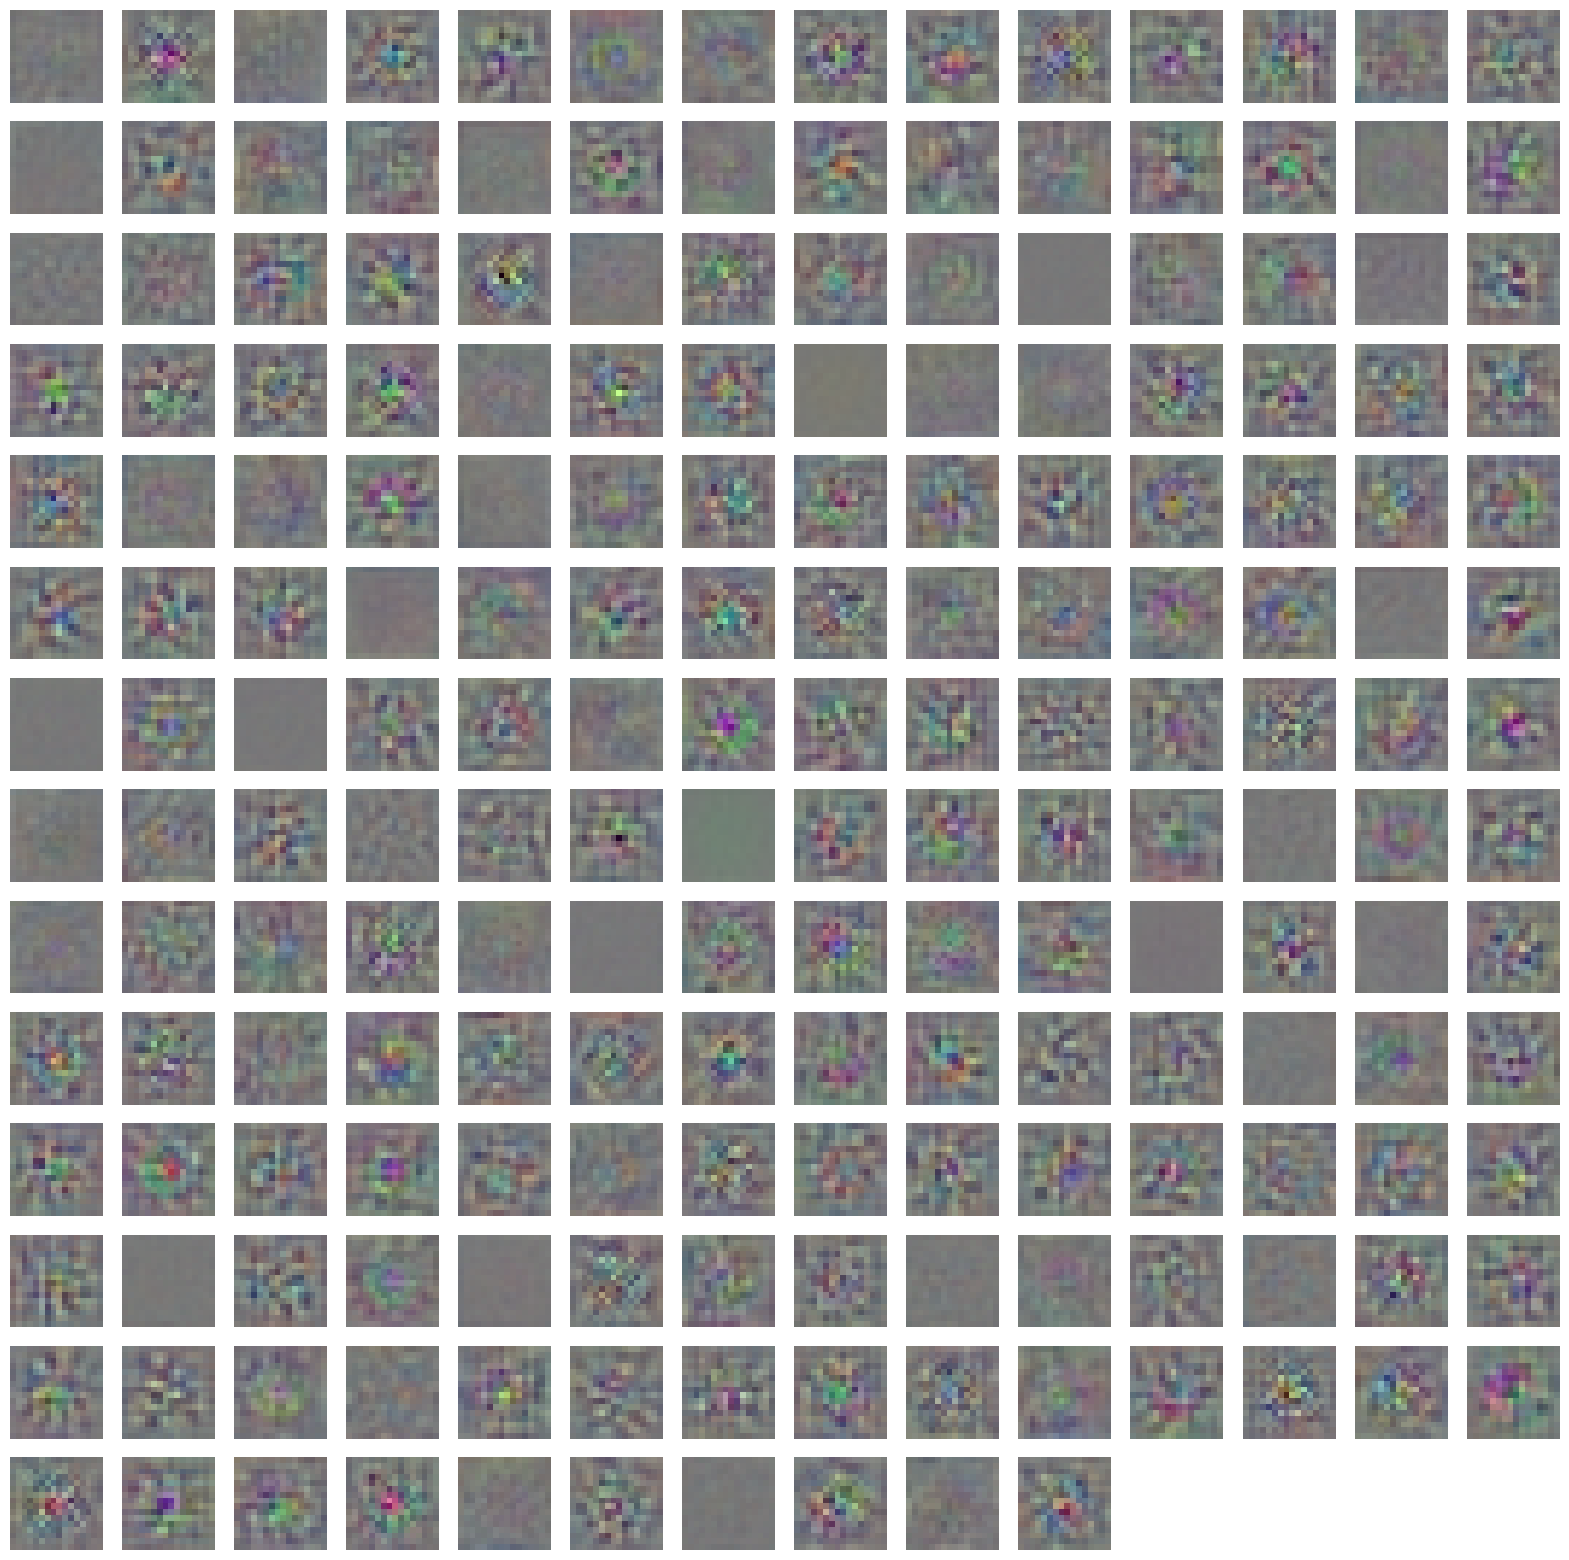

In [92]:
plt.figure(figsize=(20, 20))

for i in range(n_filters):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.imshow(filters[i].detach().numpy().transpose(1, 2, 0))
    plt.axis('off')

plt.show()